In [2]:
from PIL import Image
from pylab import *
from numpy import *
import os
from scipy.cluster.vq import *
class1 = 1.5 * randn(100,2)
class2 = randn(100,2) + array([5,5])
features = vstack((class1,class2))

In [3]:
features

array([[-3.68845197e-01,  4.27098768e-01],
       [ 2.79780350e+00,  4.26546789e-01],
       [-9.31646369e-02,  1.41925860e+00],
       [-1.03926700e+00, -1.20724994e+00],
       [-6.76012242e-01, -1.65405249e+00],
       [-7.37452422e-01, -2.69917868e+00],
       [ 2.27632386e+00, -1.42381777e-01],
       [-1.13223120e+00, -1.83744588e+00],
       [-5.32857112e-01,  1.06499569e-01],
       [ 2.45316460e+00,  2.18962699e-01],
       [-7.49471228e-01, -8.41861350e-01],
       [ 2.42858671e-01,  1.75133031e-01],
       [ 2.30401509e+00, -1.39610648e+00],
       [ 2.50163243e+00,  3.13803341e-01],
       [-3.14120892e-01, -1.27516429e+00],
       [ 1.80046319e+00,  1.94668529e+00],
       [ 1.45772319e+00, -8.79995356e-01],
       [-2.01999518e+00,  1.07327842e+00],
       [ 8.57527514e-01, -1.91636529e-01],
       [ 2.23293717e+00,  1.94579456e-01],
       [ 5.14951282e-01,  2.64977496e+00],
       [-5.91479181e-01,  4.00467444e+00],
       [-3.75765136e-01,  1.64923819e+00],
       [-2.

In [4]:
centroids,variance = kmeans(features,2)

In [5]:
centroids

array([[0.16152321, 0.37292624],
       [4.97038677, 4.8473818 ]])

In [6]:
variance

1.583150029798451

In [7]:
code,distance = vq(features,centroids)

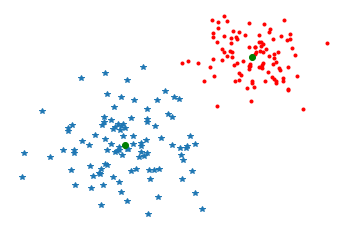

In [8]:
figure()
ndx = where(code==0)[0]
plot(features[ndx,0],features[ndx,1],'*')
ndx = where(code==1)[0]
plot(features[ndx,0],features[ndx,1],'r.')
plot(centroids[:,0],centroids[:,1],'go')
axis('off')
show()

In [10]:
def pca(X):
    num_data, dim = X.shape
    mean_X = X.mean(axis=0)
    X = X - mean_X
    if dim>num_data:
        M=dot(X,X.T)
        e,EV = linalg.eigh(M)
        tmp = dot(X.T, EV).T
        V = tmp[::-1]
        S = sqrt(e)[::-1]
        for i in range(V.shape[1]):
            v[:,i] /= S
    else:
        U,S,V = linalg.svd(X)
        V = V[:num_data]
    return V,S,mean_X

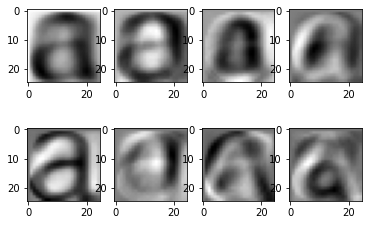

In [17]:
def get_imlist(path):
    """ 返回目录中所有 JPG 图像的文件名列表 """
    return [os.path.join(path, tmp) for tmp in os.listdir(path) if tmp.endswith('.jpg')]

imlist = get_imlist('../pics4/fontimages')
im = array(Image.open(imlist[0])) 
m,n = im.shape[0:2] 
imnbr = len(imlist) 
immatrix = array([array(Image.open(im)).flatten()
    for im in imlist],'f')
V,S,immean = pca(immatrix)
figure()
gray()
subplot(2,4,1) 
imshow(immean.reshape(m,n))
for i in range(7):
 subplot(2,4,i+2)
 imshow(V[i].reshape(m,n))
show()

In [19]:
import pickle
f = open('../pics4/font_pca_modes.pkl', 'wb')
pickle.dump(immean,f)
pickle.dump(V,f)
f.close()

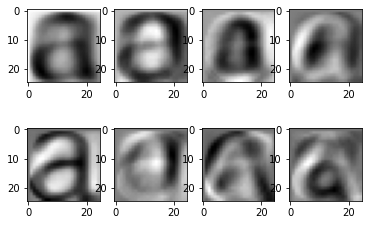

In [22]:
f = open('../pics4/font_pca_modes.pkl', 'rb')
immean = pickle.load(f)
V = pickle.load(f)
f.close()
figure()
gray()
subplot(2,4,1) 
imshow(immean.reshape(m,n))
for i in range(7):
    subplot(2,4,i+2)
    imshow(V[i].reshape(m,n))
show()

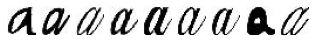

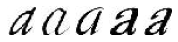

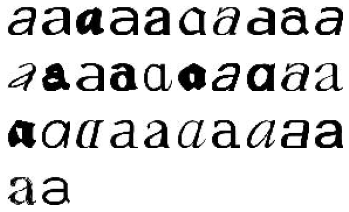

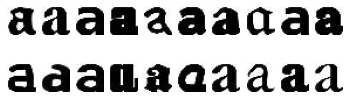

In [72]:
import pickle
from scipy.cluster.vq import *
# 获取 selected-fontimages 文件下图像文件名，并保存在列表中
imlist = get_imlist('../pics4/selectedfontimages')
imnbr = len(imlist)
# 载入模型文件
with open('../pics4/font_pca_modes.pkl','rb') as f:
    immean = pickle.load(f)
    V = pickle.load(f)
# 创建矩阵，存储所有拉成一组形式后的图像
immatrix = array([array(Image.open(im)).flatten()
 for im in imlist],'f')
# 投影到前 40 个主成分上
immean = immean.flatten()
projected = array([dot(V[:40],immatrix[i]-immean) for i in range(imnbr)])
# 进行 k-means 聚类
projected = whiten(projected)
centroids,distortion = kmeans(projected,4)
code,distance = vq(projected,centroids)

for k in range(4):
    ind = where(code==k)[0]
    figure()
    gray()
    for i in range(minimum(len(ind),40)):
        subplot(4,10,i+1)
        imshow(immatrix[ind[i]].reshape((25,25)))
        axis('off')
show()

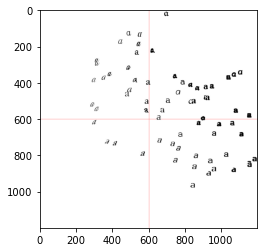

In [35]:
projected = array([dot(V[[0,2]],immatrix[i]-immean) for i in range(imnbr)])

from PIL import Image, ImageDraw
# 高和宽
h,w = 1200,1200
# 创建一幅白色背景图
img = Image.new('RGB',(w,h),(255,255,255))
draw = ImageDraw.Draw(img)
# 绘制坐标轴
draw.line((0,h/2,w,h/2),fill=(255,0,0))
draw.line((w/2,0,w/2,h),fill=(255,0,0))
# 缩放以适应坐标系
scale = abs(projected).max(0)
scaled = floor(array([ (p / scale) * (w/2-20,h/2-20) + (w/2,h/2) for p in projected]))
# 粘贴每幅图像的缩略图到白色背景图片

for i in range(imnbr):
    nodeim = Image.open(imlist[i])
    nodeim.thumbnail((25,25))
    ns = nodeim.size
    img.paste(nodeim,(int(scaled[i][0]-ns[0]//2),int(scaled[i][1]-
        ns[1]//2),int(scaled[i][0]+ns[0]//2+1),int(scaled[i][1]+ns[1]//2+1)))
img.save('pca_font.jpg')
figure()
imshow(img)
show()

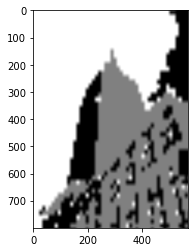

In [37]:
from scipy.cluster.vq import *
from skimage.transform import resize
steps = 50 # 图像被划分成 steps×steps 的区域
im = array(Image.open('../pics4/empire.jpg'))
dx = im.shape[0] // steps
dy = im.shape[1] // steps
# 计算每个区域的颜色特征
features = []
for x in range(steps):
    for y in range(steps):
        R = mean(im[x*dx:(x+1)*dx,y*dy:(y+1)*dy,0])
        G = mean(im[x*dx:(x+1)*dx,y*dy:(y+1)*dy,1])
        B = mean(im[x*dx:(x+1)*dx,y*dy:(y+1)*dy,2])
        features.append([R,G,B])
features = array(features,'f') # 变为数组
# 聚类
centroids,variance = kmeans(features,3)
code,distance = vq(features,centroids)
# 用聚类标记创建图像
codeim = code.reshape(steps,steps)
codeim = resize(codeim,im.shape[:2])
figure()
imshow(codeim)
show()

In [38]:
from numpy import *
from itertools import combinations
class ClusterNode(object):
    def __init__(self,vec,left,right,distance=0.0,count=1):
        self.left = left
        self.right = right
        self.vec = vec
        self.distance = distance
        self.count = count # only used for weighted average

    def extract_clusters(self,dist):
        """ Extract list of sub-tree clusters from 
            hcluster tree with distance<dist. """
        if self.distance < dist:
            return [self]
        return self.left.extract_clusters(dist) + self.right.extract_clusters(dist)

    def get_cluster_elements(self):
        """    Return ids for elements in a cluster sub-tree. """
        return self.left.get_cluster_elements() + self.right.get_cluster_elements()

    def get_height(self):
        """    Return the height of a node, 
            height is sum of each branch. """
        return self.left.get_height() + self.right.get_height()

    def get_depth(self):
        """    Return the depth of a node, depth is 
            max of each child plus own distance. """
        return max(self.left.get_depth(), self.right.get_depth()) + self.distance

    def draw(self,draw,x,y,s,imlist,im):
        """    Draw nodes recursively with image 
            thumbnails for leaf nodes. """
    
        h1 = int(self.left.get_height()*20 / 2)
        h2 = int(self.right.get_height()*20 /2)
        top = y-(h1+h2)
        bottom = y+(h1+h2)
        
        # vertical line to children    
        draw.line((x,top+h1,x,bottom-h2),fill=(0,0,0))    
        
        # horizontal lines 
        ll = self.distance*s
        draw.line((x,top+h1,x+ll,top+h1),fill=(0,0,0))    
        draw.line((x,bottom-h2,x+ll,bottom-h2),fill=(0,0,0))        
        
        # draw left and right child nodes recursively    
        self.left.draw(draw,x+ll,top+h1,s,imlist,im)
        self.right.draw(draw,x+ll,bottom-h2,s,imlist,im)
    

class ClusterLeafNode(object):
    def __init__(self,vec,id):
        self.vec = vec
        self.id = id

    def extract_clusters(self,dist):
        return [self] 

    def get_cluster_elements(self):
        return [self.id]

    def get_height(self):
        return 1

    def get_depth(self):
        return 0
    
    def draw(self,draw,x,y,s,imlist,im):
        nodeim = Image.open(imlist[self.id])
        nodeim.thumbnail([20,20])
        ns = nodeim.size
        im.paste(nodeim,[int(x),int(y-ns[1]//2),int(x+ns[0]),int(y+ns[1]-ns[1]//2)])


def L2dist(v1,v2):
    return sqrt(sum((v1-v2)**2))

    
def L1dist(v1,v2):
    return sum(abs(v1-v2))


def hcluster(features,distfcn=L2dist):
    """ Cluster the rows of features using 
        hierarchical clustering. """
    # cache of distance calculations
    distances = {}
    
    # initialize with each row as a cluster 
    node = [ClusterLeafNode(array(f),id=i) for i,f in enumerate(features)]
    
    while len(node)>1:
        closest = float('Inf')
        
        # loop through every pair looking for the smallest distance
        for ni,nj in combinations(node,2):
            if (ni,nj) not in distances: 
                distances[ni,nj] = distfcn(ni.vec,nj.vec)
                
            d = distances[ni,nj]
            if d<closest:
                closest = d 
                lowestpair = (ni,nj)
        ni,nj = lowestpair
        
        # average the two clusters
        new_vec = (ni.vec + nj.vec) / 2.0
        
        # create new node
        new_node = ClusterNode(new_vec,left=ni,right=nj,distance=closest)
        node.remove(ni)
        node.remove(nj)
        node.append(new_node)
    
    return node[0]


from PIL import Image,ImageDraw
 
def draw_dendrogram(node,imlist,filename='clusters.jpg'):
    """    Draw a cluster dendrogram and save to a file. """
    
    # height and width
    rows = node.get_height()*20
    cols = 1200
    
    # scale factor for distances to fit image width
    s = float(cols-150)/node.get_depth()
    # create image and draw object
    im = Image.new('RGB',(cols,rows),(255,255,255))
    draw = ImageDraw.Draw(im)
    
    # initial line for start of tree
    draw.line((0,rows/2,20,rows/2),fill=(0,0,0))    
    
    # draw the nodes recursively
    node.draw(draw,20,(rows/2),s,imlist,im)
    im.save(filename)
    im.show()

In [39]:
class1 = 1.5 * randn(100,2)
class2 = randn(100,2) + array([5,5])
features = vstack((class1,class2))
tree = hcluster(features)
clusters = tree.extract_clusters(5)
print('number of clusters', len(clusters))
for c in clusters:
    print(c.get_cluster_elements())

number of clusters 2
[21, 100, 169, 123, 188, 197, 120, 121, 181, 192, 124, 138, 194, 147, 162, 110, 153, 145, 171, 131, 175, 182, 196, 161, 164, 176, 198, 112, 166, 193, 134, 190, 117, 108, 116, 135, 179, 109, 119, 101, 103, 136, 102, 154, 187, 113, 199, 118, 191, 183, 125, 143, 137, 160, 155, 178, 106, 107, 141, 128, 146, 115, 156, 177, 184, 151, 129, 149, 104, 195, 180, 148, 157, 174, 105, 165, 150, 152, 170, 186, 142, 163, 167, 168, 159, 133, 185, 139, 122, 144, 172, 130, 127, 158, 173, 140, 189, 114, 132, 111, 126]
[14, 94, 87, 16, 76, 2, 61, 48, 75, 50, 55, 60, 18, 51, 69, 3, 26, 73, 90, 0, 4, 8, 22, 43, 15, 49, 46, 80, 11, 53, 25, 65, 58, 54, 59, 81, 56, 83, 9, 68, 78, 64, 84, 7, 71, 37, 99, 20, 32, 39, 52, 17, 34, 10, 47, 89, 24, 95, 96, 5, 88, 62, 31, 44, 91, 27, 41, 1, 13, 72, 30, 82, 86, 45, 12, 92, 77, 6, 79, 35, 85, 19, 42, 57, 23, 40, 63, 66, 67, 97, 70, 33, 93, 98, 74, 28, 29, 36, 38]


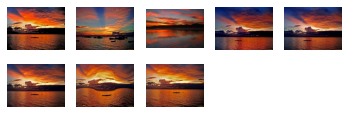

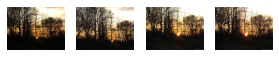

In [67]:
import os
# 创建图像列表
path = '../pics4/sunsets'
imlist = [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]
# 提取特征向量，每个颜色通道量化成 8 个小区间
features = zeros([len(imlist), 512])
for i,f in enumerate(imlist):
    im = array(Image.open(f))
 # 多维直方图
    h,edges = histogramdd(im.reshape(-1,3),8,normed=True,
        range=[(0,255),(0,255),(0,255)])
    features[i] = h.flatten()
tree = hcluster(features)

from PIL import Image,ImageDraw


def draw_dendrogram(node,imlist,filename='clusters.jpg'):
    """ 绘制聚类树状图，并保存到文件中 """
    # 高和宽
    rows = node.get_height()*20
    cols = 1200
    # 距离缩放因子，以便适应图像宽度
    s = float(cols-150)/node.get_depth()
    # 创建图像，并绘制对象
    im = Image.new('RGB',(cols,rows),(255,255,255))
    draw = ImageDraw.Draw(im)
    # 初始化树开始的线条
    draw.line((0,rows/2,20,rows/2),fill=(0,0,0))
    # 递归地画出节点
    node.draw(draw,20,(rows/2),s,imlist,im)
    im.save(filename)
    im.show()
    
# draw_dendrogram(tree,imlist,filename='sunset.pdf')
clusters = tree.extract_clusters(0.23*tree.distance)
for c in clusters:
    elements = c.get_cluster_elements()
    nbr_elements = len(elements)
    if nbr_elements>3:
        figure()
        for p in range(minimum(nbr_elements,20)):
            subplot(4,5,p+1)
            im = array(Image.open(imlist[elements[p]]))
            imshow(im)
            axis('off')
show()

In [75]:
tree = hcluster(projected)
path = '../pics4/selectedfontimages'
imlist = [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]
draw_dendrogram(tree,imlist,filename='fonts.jpg')